<a href="https://colab.research.google.com/github/harperd17/cloud_classification/blob/main/modeling/transposed_CNN_segmentation_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/harperd17/cloud_classification.git

Cloning into 'cloud_classification'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 107 (delta 8), reused 0 (delta 0), pack-reused 84
Receiving objects: 100% (107/107), 1.86 MiB | 19.62 MiB/s, done.
Resolving deltas: 100% (38/38), done.


In [ ]:
!pip install torchsat
from torchsat.transforms import transforms_seg

     |████████████████████████████████| 46 kB 1.7 MB/s 


In [ ]:
import torch
import torchvision
import glob
from PIL import Image
import cv2
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

     |████████████████████████████████| 88 kB 3.7 MB/s 
     |████████████████████████████████| 376 kB 15.6 MB/s 
     |████████████████████████████████| 58 kB 5.5 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=8210e2a2548b4e5088a2f7ecd578b60179faae05a5467c56d45dc7477716c9f5
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=059f7a4fc1787b51aceea267f7a7a7d78d64f6125ab7f6368276662a1851d59d
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels


In [ ]:
drive._mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!git clone https://github.com/EdwardRaff/Inside-Deep-Learning.git
%run /content/Inside-Deep-Learning/idlmam.py

Cloning into 'Inside-Deep-Learning'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 34 (delta 10), reused 28 (delta 7), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [ ]:
from tqdm.autonotebook import tqdm
from cloud_classification.helpers.helper_functions import CloudData, show_image_and_masks, decode_pixels, train_network, show_predicted_masks, get_accuracy, get_auc

from sklearn.metrics import roc_curve, auc

## Set up the Directory for the Images

In [ ]:
#data_dir = '/content/drive/MyDrive/Data690/Project/Data'
data_dir = '/content/drive/Shareddrives/DavidHarper_Data690_Project/Data'

## Load the train.csv which holds the file names, classifications, and mask information

In [ ]:
train_data = pd.read_csv(data_dir+'/train.csv')

In [ ]:
# now random sample from the train_data so that I don't have to train these networks on such a large amount of data - the final model should be trained with all the data though
image_names = pd.Series([parts[0] for parts in train_data['Image_Label'].str.split('_')])
sampled = pd.Series(pd.Series(image_names).unique()).sample(500)
train_data_sampled = train_data[image_names.isin(sampled)]

## Do a Train / Validation Split

In [ ]:
train_valid_images, test_images = train_test_split(sampled,train_size=0.9)
train_images, valid_images = train_test_split(train_valid_images,train_size=0.8)

In [ ]:
test = train_data[image_names.isin(test_images)]
train = train_data[image_names.isin(train_images)]
valid = train_data[image_names.isin(valid_images)]

## Create the CloudData objects and DataLoaders

In [ ]:
output_width=512
output_height=512

test_dataset = CloudData(data_dir, test, output_width=output_width, output_height=output_height)#, transform=transform_list)
train_dataset = CloudData(data_dir, train, output_width=output_width, output_height=output_height)#, transform=transform_list)
valid_dataset = CloudData(data_dir, valid, output_width=output_width, output_height=output_height)#, transform=transform_list)

print("There are {} test images".format(len(test_dataset)))
print("There are {} train images".format(len(train_dataset)))
print("There are {} valid images".format(len(valid_dataset)))

batch_size = 8

test_loader = DataLoader(test_dataset,batch_size=batch_size)
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=batch_size)

There are 50 test images
There are 360 train images
There are 90 valid images


/content/cloud_classification/helpers/helper_functions.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['Label'] = [parts[1] for parts in mask_df['Image_Label'].str.split('_')]
/content/cloud_classification/helpers/helper_functions.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mask_df['Image'] = [parts[0] for parts in mask_df['Image_Label'].str.split('_')]


## Get the GPU Device Configured

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Modeling

In [ ]:
C = 3
n_filters = 64
classes = 4

In [ ]:
#Define our helper function that creates a hidden layer for a CNN - this function was copied from the text
def cnnLayer(in_filters, out_filters, kernel_size=3):
 """
 in_filters: how many channels are in the input to this layer
 out_filters: how many channels should this layer output
 kernel_size: how large should the filters of this layer be
 """
 padding = kernel_size//2
 return nn.Sequential( 
 nn.Conv2d(in_filters, out_filters, kernel_size, padding=padding), 
 nn.BatchNorm2d(out_filters),
 nn.LeakyReLU(), # I'm not setting the leak value to anything just to make the code shorter. 
 )


In [ ]:
def pool_and_cnn(input_filters, num_cnn_layers=2):
  return nn.Sequential(
      nn.MaxPool2d(2),
      cnnLayer(input_filters, 2*input_filters),
      *[cnnLayer(2*input_filters, 2*input_filters) for _ in range(num_cnn_layers-1)]      
  )

In [ ]:
def transpose_and_cnn(input_filters, num_cnn_layers = 2):
  return nn.Sequential(
      nn.ConvTranspose2d(input_filters, int(input_filters/2), (3,3), padding=1, output_padding=1, stride=2),
      nn.BatchNorm2d(int(input_filters/2)),
      nn.LeakyReLU(),
      *[cnnLayer(int(input_filters/2), int(input_filters/2)) for _ in range(num_cnn_layers)]
  )

In [ ]:
segmentation_model_transposes = nn.Sequential(
    cnnLayer(C, n_filters),
    cnnLayer(n_filters, n_filters),
    pool_and_cnn(n_filters),
    pool_and_cnn(n_filters*2),
    pool_and_cnn(n_filters*4),
    pool_and_cnn(n_filters*8),
    pool_and_cnn(n_filters*16),
    # pool_and_cnn(n_filters*32),
    # transpose_and_cnn(n_filters*64),
    transpose_and_cnn(n_filters*32),
    transpose_and_cnn(n_filters*16),
    transpose_and_cnn(n_filters*8),
    transpose_and_cnn(n_filters*4),
    transpose_and_cnn(n_filters*2),
    nn.Conv2d(n_filters, classes, (3,3), padding=1)
)

In [ ]:
segmentation_model_transposes = segmentation_model_transposes.apply(weight_reset)

In [ ]:
loss_func = smp.losses.DiceLoss(mode='multilabel')
optimizer = torch.optim.Adam(segmentation_model_transposes.parameters())#,lr=0.01)

In [ ]:
seg_results_transpose = train_network(segmentation_model_transposes, loss_func, train_loader, epochs=25, device=device, val_loader=valid_loader,score_funcs={'Accuracy':get_accuracy,'AUC':get_auc})

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Training:   0%|          | 0/45 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


Validating:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:1001: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning,


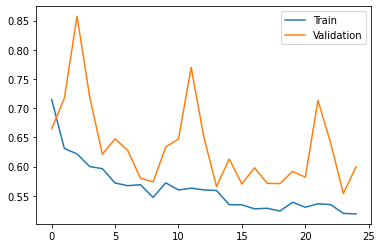

In [ ]:
plt.plot(seg_results_transpose['train loss'],label='Train')
plt.plot(seg_results_transpose['val loss'],label='Validation')
plt.legend();

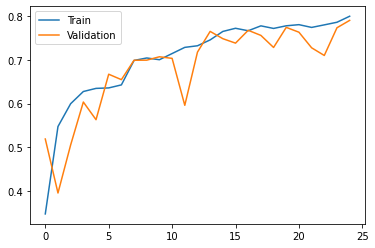

In [ ]:
plt.plot(seg_results_transpose['train Accuracy'],label='Train')
plt.plot(seg_results_transpose['val Accuracy'],label='Validation')
plt.legend();

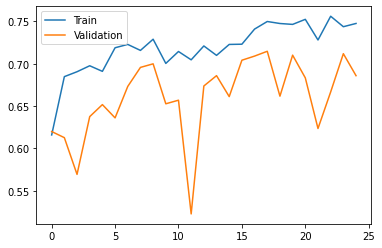

In [ ]:
plt.plot(seg_results_transpose['train AUC'],label='Train')
plt.plot(seg_results_transpose['val AUC'],label='Validation')
plt.legend();

In [ ]:
segmentation_model_transposes = segmentation_model_transposes.cpu()

(<Figure size 864x1296 with 42 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f19cfe9c890>,
       dtype=object))

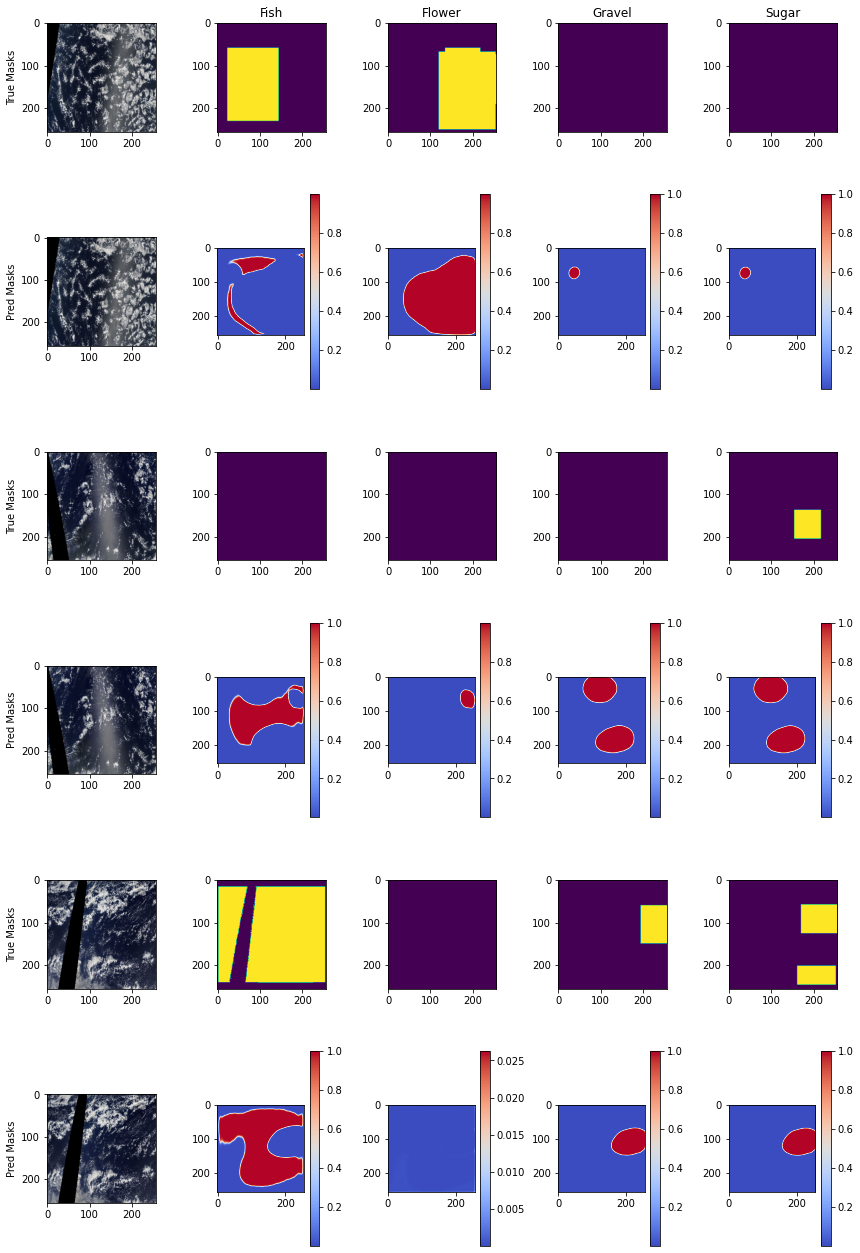

In [ ]:
to_show = 3
with torch.no_grad():
  sample_predictions = [segmentation_model_transposes(train_dataset[i][0].unsqueeze(0)).squeeze(0) for i in range(to_show)]
  sample_masks = [train_dataset[i][1] for i in range(to_show)]
  original_images = [train_dataset[i][0].permute(1,2,0) for i in range(to_show)]
show_predicted_masks(sample_predictions,sample_masks, original_images,classes=train_dataset.classes);

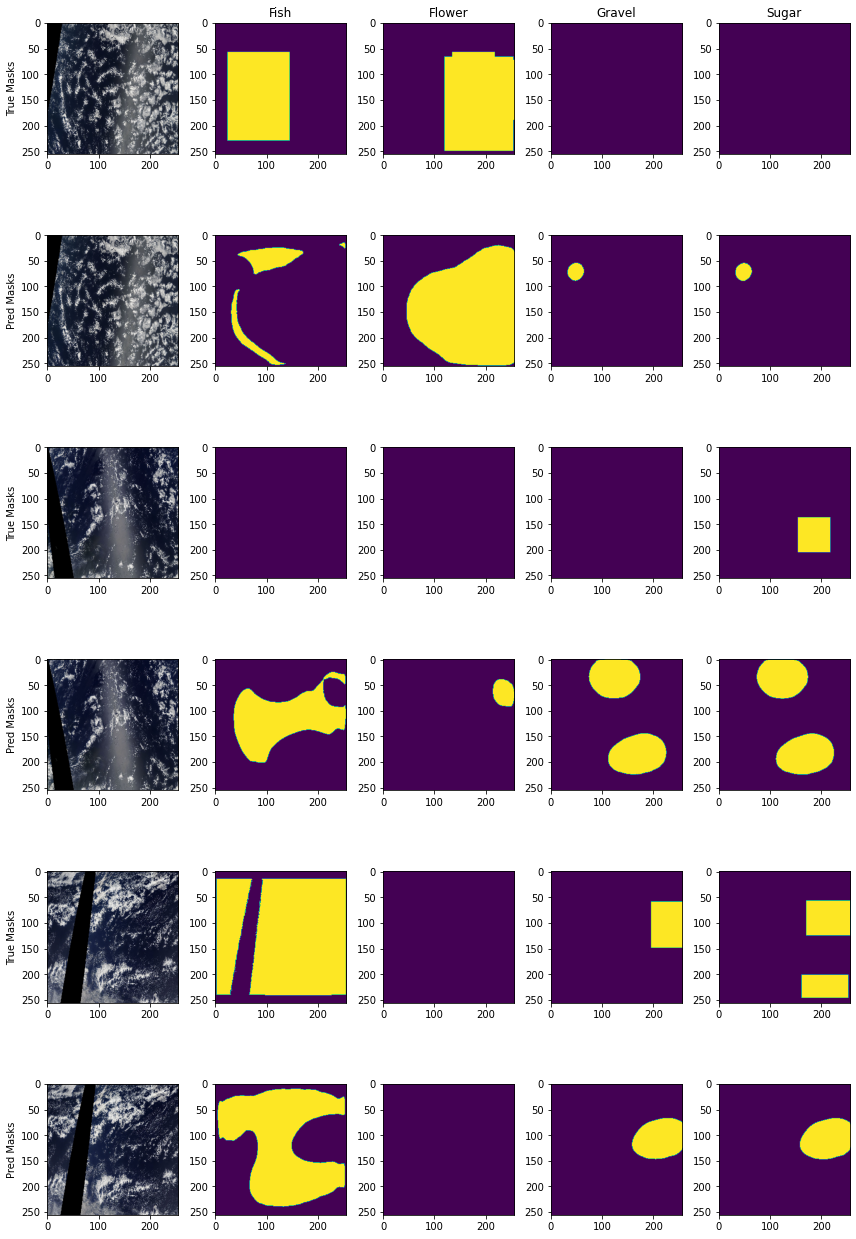

In [ ]:
# now show what the predicted mask is using a threshold
thresh = 0.5
sample_pred_masks = [(s>thresh).float() for s in sample_predictions]
show_predicted_masks(sample_pred_masks,sample_masks, original_images,classes=train_dataset.classes,cmap=None);